In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [273]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D, LeakyReLU, BatchNormalization, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [274]:
data = pd.read_csv('./BSACTData.csv', index_col='Timestamp')
data = data.dropna()

In [277]:
data['block-gen-mu'] = 560
data['tx-gen-time'] = 26.66

In [276]:
data = pd.read_csv('./BSACTDataII.csv', index_col='Timestamp')
data = data[:5000]

In [278]:
data.head()

,mempool-size,transactions-per-second,median-confirmation-time,transaction-fees,n-transactions-per-block,block-gen-mu,tx-gen-time
Timestamp,,,,,,,
2016-06-14 14:45:00,22589818.0,2.850000,13.044534,163.686453,1649.658883,560,26.66
2016-06-14 15:00:00,23395603.0,2.900000,11.540231,163.148091,1004.688315,560,26.66
2016-06-14 15:15:00,23095796.0,3.333333,12.938979,179.227342,1834.375260,560,26.66
2016-06-14 15:30:00,22710508.0,3.533333,14.100040,184.766794,1648.088803,560,26.66
2016-06-14 15:45:00,23625103.0,3.050000,11.947961,214.149393,2060.941785,560,26.66


In [279]:
data.shape

(5000, 7)

In [280]:
X = data.drop(columns=['median-confirmation-time', 'transaction-fees', 'n-transactions-per-block'])
y = data.loc[:, ['median-confirmation-time']]

In [281]:
def split_dataset(X, y, split=0.25, look_back=7, num_step=3):
    len_split = int(np.shape(X)[0]*split)
    
    _X_train, _X_test = X[:-len_split], X[-len_split:-num_step]
    _y_train, _y_test = y[:-len_split], y[-len_split:-num_step]
    
    m, n = np.shape(_X_train)
    X_train = np.zeros((m-look_back-num_step, look_back, n))
    y_train = np.zeros((m-look_back-num_step, num_step))
    for i in range(look_back-1, m-num_step):
        X_train[i-look_back-1] = _X_train[i-(look_back-1):i+1]
        y_train[i-look_back-1] = _y_train[i:i+(num_step)]
    
    m, n = np.shape(_X_test)
    X_test = np.zeros((m-look_back-num_step, look_back, n))
    y_test = np.zeros((m-look_back-num_step, num_step))
    for i in range(look_back-1, m-num_step):
        X_test[i-look_back-1] = _X_test[i-(look_back-1):i+1]
        y_test[i-look_back-1] = _y_test[i:i+(num_step)]

    return X_train, X_test, y_train, y_test

In [295]:
def build_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = np.shape(X_train)[1], np.shape(X_train)[2], np.shape(y_train)[1]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_timesteps, n_features), return_sequences=True))
    # model.add(LSTM(50, input_shape=(n_timesteps, n_features)))
    model.add(LSTM(100, return_sequences=True))
    model.add(LeakyReLU())

    model.add(LSTM(500, return_sequences=True))
    model.add(LeakyReLU())
    
    model.add(LSTM(100, return_sequences=True))
    model.add(LeakyReLU())

    model.add(LSTM(50))
    model.add(LeakyReLU())    

    model.add(Dense(100))
    model.add(LeakyReLU())
    # model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(100))
    model.add(LeakyReLU())
    # model.add(BatchNormalization())
    
    model.add(Dense(n_outputs))
    model.add(LeakyReLU())
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [296]:
arr_y = [_[0] for _ in y.values]
X_train, X_test, y_train, y_test = split_dataset(X.values, arr_y)

In [297]:
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((3740, 7, 4), (1237, 7, 4), (3740, 3), (1237, 3))

In [303]:
model = build_model(X_train, y_train)

In [304]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 7, 50)             11000     
_________________________________________________________________
lstm_56 (LSTM)               (None, 7, 100)            60400     
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 7, 100)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 7, 500)            1202000   
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 7, 500)            0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7, 100)            240400    
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 7, 100)            0         
__________

In [305]:
verbose, epochs, batch_size = 1, 30, 16
early_stopping_monitor = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping_monitor], shuffle=False);
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2);

Train on 2992 samples, validate on 748 samples
Epoch 1/30
2992/2992 [==============================] - 17s 6ms/step - loss: 61.3957 - val_loss: 28.3676
Epoch 2/30
2992/2992 [==============================] - 11s 4ms/step - loss: 17.8590 - val_loss: 14.9556
Epoch 3/30
2992/2992 [==============================] - 11s 4ms/step - loss: 14.3071 - val_loss: 13.9006
Epoch 4/30
2992/2992 [==============================] - 11s 4ms/step - loss: 14.0858 - val_loss: 13.7511
Epoch 5/30
2992/2992 [==============================] - 10s 3ms/step - loss: 13.9800 - val_loss: 13.6956
Epoch 6/30
2992/2992 [==============================] - 10s 3ms/step - loss: 13.9421 - val_loss: 13.7107
Epoch 7/30
2992/2992 [==============================] - 10s 3ms/step - loss: 14.0095 - val_loss: 13.7014
Epoch 8/30
2992/2992 [==============================] - 10s 3ms/step - loss: 14.1069 - val_loss: 13.6870
Epoch 9/30
2992/2992 [==============================] - 10s 3ms/step - loss: 14.1317 - val_loss: 13.6875
Epoch 10

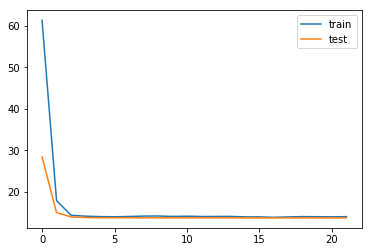

In [306]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

5.844512115255987


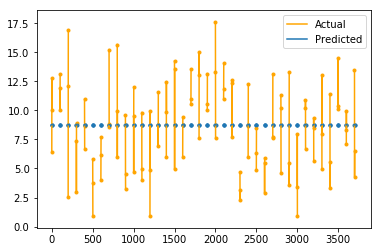

In [307]:
y_pred = model.predict(X_train)
print(normError(y_train, y_pred))
evalPlot(y_train, y_pred)

# Evaluation

In [162]:
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [20, 10]

In [163]:
def normError(y_true, t_pred):
    error = 0
    for i in range(np.shape(y_true)[0]):
        error+=np.linalg.norm(y_true[i] - y_pred[i])
    return error/np.shape(y_true)[0]

In [259]:
def evalPlot(y_true, y_pred):
    m, n = np.shape(y_true)
    X = np.arange(m+n)
    plt.figure()
    skip = 100
    plt.plot(X[:n], y_true[0], color='orange', label='Actual')
    plt.plot(X[:n], y_pred[0], color='C0', label='Predicted')
    for j in range(n):
        plt.scatter(X[j], y_true[0][j], marker='.', color='orange')
        plt.scatter(X[j], y_pred[0][j], marker='.', color='C0')
    
    for i in range(skip, m, skip):
        plt.plot(X[i:i+n], y_true[i], color='orange')
        plt.plot(X[i:i+n], y_pred[i], color='C0')
        for j in range(n):
            plt.scatter(X[i+j], y_true[i][j], marker='.', color='orange')
            plt.scatter(X[i+j], y_pred[i][j], marker='.', color='C0')
    plt.legend()
    plt.show()

# Train

In [270]:
temp0 = X_train[0].reshape((1, 7, 4))
temp1 = X_train[1].reshape((1, 7, 4))

In [271]:
model.predict(temp0), model.predict(temp1)

(array([[ 0.8788384 , -0.08665359,  1.7738523 ]], dtype=float32),
 array([[ 0.8788384 , -0.08665359,  1.7738523 ]], dtype=float32))

In [167]:
y_pred = model.predict(X_train)

In [170]:
normError(y_train, y_pred)

5.7186006382816945

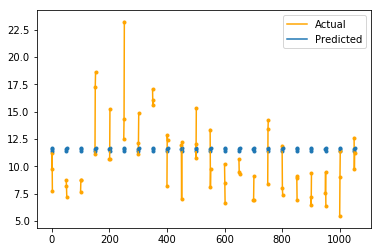

In [171]:
evalPlot(y_train, y_pred)

# Test

In [30]:
y_pred = model.predict(X_test)

In [31]:
normError(y_test, y_pred)

6.433139718175208

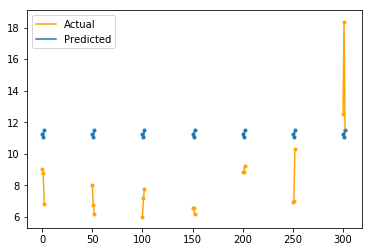

In [32]:
evalPlot(y_test, y_pred)